<a href="https://colab.research.google.com/github/davidsonsantana89/RNA-e-Deep-Learning---CESAR-School-2023.02/blob/main/Projeto%20Final%20da%20Disciplina/dass_projeto_final_versao_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOME: DAVIDSON ALVES SANTOS DE SANTANA

E-MAIL: dass@cesar.school

LINK PARA DATASET ESCOLHIDO: [Classificador de Imagens do Bart e Homer Simpson](https://www.kaggle.com/datasets/juniorbueno/neural-networks-homer-and-bart-classification/data)

# BIBLIOTECAS DO PROJETO

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# CLASSES E FUNÇÕES

## CLASSES

### CRIAÇÃO DA CLASSE `MeuDataset`

In [ ]:
class MeuDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Converte para escala de cinza
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### CRIAÇÃO DA CLASSE `Modelo`

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(100*200, 10000),
            nn.ReLU(),
            nn.Linear(10000, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2),
        )

    def forward(self, x):
        x = self.dense(x)
        return x


## FUNÇÕES

### FUNÇÃO `predict`

In [ ]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

### FUNÇÃO `imshow`

In [ ]:
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

### FUNÇÃO `train`

In [ ]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

### FUNÇÃO `test`

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0), -1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# CARREGAMENTO DOS DADOS, TREINAMENTO E AVALIAÇÃO DO MODELO

## OBTENÇÃO DOS DADOS

In [ ]:
# Clone o repositório do GitHub
!git clone https://github.com/davidsonsantana89/RNA-e-Deep-Learning---CESAR-School-2023.02.git

fatal: destination path 'RNA-e-Deep-Learning---CESAR-School-2023.02' already exists and is not an empty directory.


## CARREGAMENTO DOS DADOS

In [ ]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(1111)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 80, 'shuffle':True}
test_kwargs = {'batch_size': 14, 'shuffle':True}
if use_cuda:
    cuda_kwargs = {'num_workers': 2,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


transform = transforms.Compose([
    transforms.Resize((100, 200)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalização para um canal
])

In [ ]:
train_dir = '/content/RNA-e-Deep-Learning---CESAR-School-2023.02/arquivos_projeto_final/dataset_personagens/training_set'
test_dir = '/content/RNA-e-Deep-Learning---CESAR-School-2023.02/arquivos_projeto_final/dataset_personagens/test_set'

train_dataset = MeuDataset(root_dir=train_dir, transform=transform)
test_dataset = MeuDataset(root_dir=test_dir, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

classe_0, classe_1 = train_dataset.classes

In [ ]:
print(f"O train_dataset possui {len(train_dataset)} dados de treinamento.")
print(f"Enquanto test_dataset possui {len(test_dataset)} dados de teste.")
print(f"As classes presentes em train_dataset são '{classe_0}'(classe 0) e '{classe_1}'(classe 1).")

O train_dataset possui 196 dados de treinamento.
Enquanto test_dataset possui 73 dados de teste.
As classes presentes em train_dataset são 'bart'(classe 0) e 'homer'(classe 1).


In [ ]:
# Iterar sobre o DataLoader e obter as dimensões das imagens
for images, labels in train_loader:
    print(f'Dimensão das imagens: {images.shape}')
    # Imprimir as dimensões das imagens individuais no lote
    for img in images:
        print(f'Dimensão da imagem: {img.shape}')
    # break  # Remover ou comentar isso para iterar sobre todo o DataLoader

Dimensão das imagens: torch.Size([80, 1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Size([1, 100, 200])
Dimensão da imagem: torch.Si

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Amostras de treinamento:", len(train_loader))

print("\nDimensões dos dados das imagens:   ", images[0].shape)
print("Valores mínimo e máximo dos pixels:", torch.min(images), torch.max(images))
print("Tipo dos dados das imagens:        ", type(images))
print("Tipo das classes das imagens:      ", type(labels))

Amostras de treinamento: 3

Dimensões dos dados das imagens:    torch.Size([1, 100, 200])
Valores mínimo e máximo dos pixels: tensor(-1.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


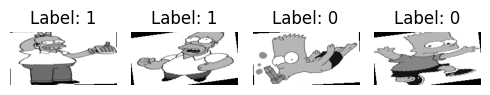

In [ ]:
# Mostrar quatro imagens de teste
fig, axs = plt.subplots(1, 4, figsize=(5, 5))

for i in range(4):
    axs[i].imshow(images[i].numpy().squeeze(), cmap='gray')
    axs[i].set_title(f'Label: {labels[i].item()}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## CRIAÇÃO DO MODELO

In [ ]:
model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=20000, out_features=10000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10000, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=2, bias=True)
  )
)


In [ ]:
# Testando a rede criada
input = images.reshape(-1, 200*100)
pred = predict(model, input)
print(pred)
print(input.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
torch.Size([80, 20000])


In [ ]:
# Testando a rede criada
input = torch.ones((1,200*100))
y_pred = predict(model, Variable(input))
print(y_pred)

[1]


## TREINAMENTO DO MODELO

In [ ]:
# Definir o otimizador (por exemplo, SGD)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Criar o scheduler StepLR
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

epochs = 2000

for epoch in range(1, epochs + 1):
    train(10, False, model.to(device), device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

torch.save(model.state_dict(), "homer_bart_clf.pt")

A saída de streaming foi truncada nas últimas 5000 linhas.
Train Epoch: 751 [0/196 (0%)]	Loss: 0.597938

Test set: Average loss: 0.5926, Accuracy: 51/73 (70%)

Train Epoch: 752 [0/196 (0%)]	Loss: 0.609914

Test set: Average loss: 0.6053, Accuracy: 48/73 (66%)

Train Epoch: 753 [0/196 (0%)]	Loss: 0.592525

Test set: Average loss: 0.6101, Accuracy: 48/73 (66%)

Train Epoch: 754 [0/196 (0%)]	Loss: 0.595801

Test set: Average loss: 0.6023, Accuracy: 47/73 (64%)

Train Epoch: 755 [0/196 (0%)]	Loss: 0.564308

Test set: Average loss: 0.5963, Accuracy: 51/73 (70%)

Train Epoch: 756 [0/196 (0%)]	Loss: 0.592778

Test set: Average loss: 0.6017, Accuracy: 50/73 (68%)

Train Epoch: 757 [0/196 (0%)]	Loss: 0.562298

Test set: Average loss: 0.6219, Accuracy: 47/73 (64%)

Train Epoch: 758 [0/196 (0%)]	Loss: 0.577164

Test set: Average loss: 0.6121, Accuracy: 45/73 (62%)

Train Epoch: 759 [0/196 (0%)]	Loss: 0.542786

Test set: Average loss: 0.6132, Accuracy: 50/73 (68%)

Train Epoch: 760 [0/196 (0%)]	Lo

## CONCLUSÃO

Uma dificuldade inicial neste projeto foi no momento de definir o conjunto de treino e o de teste. Inicialmente, baixei as imagens, mas numa versão onde todas as imagens, ao descompactar o arquivo, estavam em um único diretório.

Mas após uma pesquisa no ChatGPT entendi que cada classe, de classificação, deveria estar em seu diretório próprio. Daí, comecei um trabalho braçal de separar as imagens por classe e alocá-las em seu diretório. Entretanto, percebendo que seria muito trabalhoso fazer tal tarefa de separação, voltei ao endereço do Kaggle onde eu havia baixado na primeira vez e me deparei com uma versão para download, no mesmo link, que já trazia todas as imagens separadas em treino e teste, cada uma em seu diretório próprio: no diretório dos dados de treino havia os subdiretórios classe 0 e classe 1, respectivamente. Assim como no diretório de teste.

Uma segunda dificuldade que encontrei foi o fato das imagens não estarem em escala de cinza ou preto e branco, mas em RGB. Pois não tinha visto exemplos em RGB, mas como o professor falou em uma das aulas que seria necessário fazer uma transformação de cor nas imagens, fiz uma pesquisa na documentação do Torch em busca de transformação para escala de cinza.

Quantos neurônios utilizar? Quantas camadas? Dúvidas e dificuldades. Como não poderia utilziar convolução, fui fazendo experimentos, tentando atingir ao menos 80% de acurácia, entretanto utilizando o Colab básico não é possível aumentar o número de neurônios. Então fiz experimentações na minha conta pessoal, comprando unidades processamento. Houve um penqueno aumento de 58% para 64% ao final de 2000, salientando-se que na época 1174 atingiu-se 73% de acurácia.